In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download lplenka/coco-car-damage-detection-dataset

 62% 9.00M/14.4M [00:00<00:00, 29.0MB/s]
100% 14.4M/14.4M [00:00<00:00, 40.9MB/s]


In [5]:
! unzip coco-car-damage-detection-dataset.zip -d /input

Archive:  coco-car-damage-detection-dataset.zip
  inflating: /input/img/1.jpg        
  inflating: /input/img/10.jpg       
  inflating: /input/img/13.jpg       
  inflating: /input/img/14.jpg       
  inflating: /input/img/15.jpg       
  inflating: /input/img/16.jpg       
  inflating: /input/img/17.jpg       
  inflating: /input/img/18.jpg       
  inflating: /input/img/19.jpg       
  inflating: /input/img/2.jpg        
  inflating: /input/img/20.jpg       
  inflating: /input/img/21.jpg       
  inflating: /input/img/22.jpg       
  inflating: /input/img/23.jpg       
  inflating: /input/img/24.jpg       
  inflating: /input/img/25.jpg       
  inflating: /input/img/26.jpg       
  inflating: /input/img/27.jpg       
  inflating: /input/img/29.jpg       
  inflating: /input/img/3.jpg        
  inflating: /input/img/30.jpg       
  inflating: /input/img/31.jpg       
  inflating: /input/img/32.jpg       
  inflating: /input/img/33.jpg       
  inflating: /input/img/34.jpg       
  

In [6]:
!ls /input

img  test  train  val


In [1]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt

# Load Data

## Use COCO API to show data

In [2]:
# The coco api can be found here.
# https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

### Multi annotation

In [7]:
trainDir = '/input/train/'
annFile = f'{trainDir}COCO_mul_train_annos.json'
# COCO_mul_train_annos.json
# COCO_train_annos.json
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [8]:
cats = coco.loadCats(coco.getCatIds())

In [9]:
cats

[{'id': 1, 'name': 'headlamp', 'supercategory': 'part'},
 {'id': 2, 'name': 'rear_bumper', 'supercategory': 'part'},
 {'id': 3, 'name': 'door', 'supercategory': 'part'},
 {'id': 4, 'name': 'hood', 'supercategory': 'part'},
 {'id': 5, 'name': 'front_bumper', 'supercategory': 'part'}]

### Single annotation 
<p style="color:red;">(this project uses this for single instance segmentation)</p>

In [10]:
trainDir = '/input/train/'
annFile = f'{trainDir}COCO_train_annos.json'
# COCO_mul_train_annos.json
# COCO_train_annos.json
coco=COCO(annFile)

cats = coco.loadCats(coco.getCatIds())
cats

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


[{'id': 1, 'name': 'damage', 'supercategory': 'part'}]

In [11]:
print('COCO categories: {}'.format(
    ' '.join(
  [cat['name'] for cat in cats])
))

print('COCO SUPERcategories: {}'.format(
    ' '.join(
  [cat['supercategory'] for cat in cats])
))

COCO categories: damage
COCO SUPERcategories: part


### Get images based on category

In [12]:
categoriesIDS = coco.getCatIds(catNms=['damage'])
imgIDS = coco.getImgIds(catIds=categoriesIDS)
exampleImg = coco.loadImgs(
    imgIDS[
           np.random.randint(0,len(imgIDS))
    ]
)[0]

In [13]:
print(exampleImg)

{'coco_url': '', 'date_captured': '2020-07-14 09:59:34.190485', 'file_name': '46.jpg', 'flickr_url': '', 'height': 1024, 'id': 29, 'license': 1, 'width': 1024}


(-0.5, 1023.5, 1023.5, -0.5)

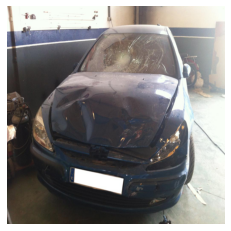

In [14]:
import matplotlib.image as mpimg
img = mpimg.imread(trainDir+exampleImg['file_name'])
plt.imshow(img)
plt.axis('off')

### Load and display annotations

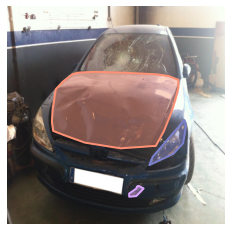

In [15]:
plt.imshow(img)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=exampleImg['id'], catIds=imgIDS, iscrowd=None)
coco.showAnns(
    coco.loadAnns(annIds)
)

# Pytorch

## Creating dataset

In [17]:
import os
import torch
from PIL import Image
from engine import train_one_epoch, evaluate

In [18]:
class VehicleDamageDataset(torch.utils.data.Dataset):
  def __init__(self, path, annFileName, categories=[]):
    self.path = path
    self.annFile = f'{self.path}{annFileName}'
    # COCO_mul_train_annos.json
    # COCO_train_annos.json
    self.coco=COCO(self.annFile)

    categoriesID = self.coco.getCatIds(catNms=categories)
    self.imgIDS = list(sorted(self.coco.imgs.keys()))

  def __getitem__(self, idx):

    imgId = self.imgIDS[idx]
    annIds = self.coco.getAnnIds(imgIds=imgId)
    cocoAnn = self.coco.loadAnns(annIds)

    imgPath = self.coco.loadImgs(ids=imgId)[0]['file_name']
    img = Image.open(self.path+imgPath).convert('RGB')

    numObjects = len(cocoAnn)

    boxes = []
    for ann in range(numObjects):
      xmin = cocoAnn[ann]['bbox'][0]
      ymin = cocoAnn[ann]['bbox'][1]
      xmax = xmin + cocoAnn[ann]['bbox'][2]
      ymax = ymin + cocoAnn[ann]['bbox'][3]
      boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((numObjects), dtype=torch.int64)
    img_id = torch.tensor([imgId])
    areas = []
    for i in range(numObjects):
        areas.append(cocoAnn[i]['area'])
    areas = torch.as_tensor(areas, dtype=torch.float32)
    iscrowd = torch.zeros((numObjects,), dtype=torch.int64)

    masks = np.zeros((numObjects, img.size[0], img.size[0]))

    for i in range(numObjects):
      masks[i,:,:] = self.coco.annToMask(
          cocoAnn[i]
      )

    target = {}

    target['boxes']=boxes
    target['masks']=torch.tensor(masks, dtype=torch.uint8)
    target['labels']=labels
    target['image_id']=img_id
    target['area']=areas
    target['iscrowd']=iscrowd

    from torchvision import transforms
    tnfs = transforms.Compose([
                  transforms.ToTensor()
    ])

    return tnfs(img), target

  def __len__(self):
    return len(self.imgIDS)


## Result of format given by dataloaders

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

trainDataset = VehicleDamageDataset('/input/train/', 'COCO_train_annos.json', ['damage'])
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [20]:
trainDataset = VehicleDamageDataset(trainDir, 'COCO_train_annos.json', ['damage'])
for img, target in trainDataset:
  print(target)
  break

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
{'boxes': tensor([[300., 216., 379., 238.],
        [226., 230., 288., 264.],
        [161., 276., 226., 344.],
        [254., 273., 321., 299.],
        [233., 392., 356., 487.],
        [314., 625., 663., 663.],
        [213., 514., 241., 528.],
        [316., 514., 345., 527.],
        [433., 513., 454., 528.],
        [531., 515., 556., 526.]]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],

## Importing model

### Single forward

In [22]:
# Just load the model and perform a single forward operation, to see the output and if the data is correctly loaded.
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

images, targets = next(iter(trainLoader))
images = list(image for image in images)
print(targets)
targets = [{k: v for k, v in t.items()} for t in targets]
print(targets)
output = model(images, targets)
output

({'boxes': tensor([[ 492.,  468.,  730., 1007.]]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'labels': tensor([1]), 'image_id': tensor([2]), 'area': tensor([16813.]), 'iscrowd': tensor([0])},)
[{'boxes': tensor([[ 492.,  468.,  730., 1007.]]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'labels': tensor([1]), 'image_id': tensor([2]), 'area': tensor([16813.]), 'iscrowd': tensor([0])}]


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'loss_box_reg': tensor(0.0786, grad_fn=<DivBackward0>),
 'loss_classifier': tensor(0.1640, grad_fn=<NllLossBackward0>),
 'loss_objectness': tensor(0.0328, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0029, grad_fn=<DivBackward0>)}

In [ ]:
output

{'loss_box_reg': tensor(0.0509, grad_fn=<DivBackward0>),
 'loss_classifier': tensor(0.3785, grad_fn=<NllLossBackward0>),
 'loss_objectness': tensor(0.4311, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0236, grad_fn=<DivBackward0>)}

### Testing with random data

In [68]:
model.eval()
x = [torch.rand(images[0].size()[0], images[0].size()[1], images[0].size()[2])]
predictions = model(x) 
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

## Load pretrained model for fine-Tune.

In [69]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def ModelForInstanceSegmentation(numClasses, min_size=1024):
      model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, min_size=min_size)
      
      in_features = model.roi_heads.box_predictor.cls_score.in_features
      model.roi_heads.box_predictor = FastRCNNPredictor(in_features, numClasses)
      
      in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
      hidden_layer = 256

      model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       numClasses)

      return model

## Definition of train function

In [74]:
from engine import train_one_epoch, evaluate
import utils
def Train():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    trainDataset = VehicleDamageDataset(trainDir, 'COCO_train_annos.json', ['damage'])
    trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, shuffle=True, collate_fn=collate_fn)

    valDataset = VehicleDamageDataset('/input/val/', 'COCO_val_annos.json', ['damage'])
    valLoader = torch.utils.data.DataLoader(valDataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

    model = ModelForInstanceSegmentation(numClasses)

    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001,
                                momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    for epoch in range(numEpochs):
        train_one_epoch(model, optimizer, trainLoader, device, epoch, print_freq=10)
        lr_scheduler.step()
        evaluate(model, valLoader, device)
    return model

## Training and validation

In [75]:
numEpochs = 10
# The number of classes is two, given the background count as 1 as a whole, thile the damage is the other class.
numClasses = 2
batchSize = 2
model = Train()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch: [0]  [ 0/30]  eta: 0:01:01  lr: 0.000035  loss: 5.3928 (5.3928)  loss_classifier: 0.9952 (0.9952)  loss_box_reg: 0.1364 (0.1364)  loss_mask: 1.8507 (1.8507)  loss_objectness: 2.3099 (2.3099)  loss_rpn_box_reg: 0.1006 (0.1006)  time: 2.0380  data: 0.1609  max mem: 4608
Epoch: [0]  [10/30]  eta: 0:00:38  lr: 0.000380  loss: 2.8838 (3.0482)  loss_classifier: 0.8167 (0.6881)  loss_box_reg: 0.1412 (0.1731)  loss_mask: 1.7117 (1.7911)  loss_objectness: 0.1192 (0.3670)  loss_rpn_box_reg: 0.0159 (0.0289)  time: 1.9431  data: 0.1050  max mem: 4882
Epoch: [0]  [20/30]  eta: 0:00:19  lr: 0.000724  loss: 1.6496 (2.1803)  loss_classifier: 0.2425 (0.4443)  loss_box_reg: 0.1544 (0.1671)  loss_mask: 1.1085 (1.3204)  loss_objectness: 0.0696 (0.2289)  loss_rpn_box_reg: 0.0090 (0.0196)  time: 1.9230  data: 0.0933  max mem: 4882
Epoch:

In [106]:
!ls /input/test

11.jpg	12.jpg	28.jpg	45.jpg	60.jpg	66.jpg	67.jpg	72.jpg


In [114]:
def ShowPredictions(imgPath='/input/test/', imgName='11.jpg', scoreTreshold=0.5):
  with torch.no_grad():
    model.eval()

    from torchvision import transforms
    imgTest = Image.open(imgPath+imgName).convert('RGB')
    preprocess = transforms.Compose([
            transforms.ToTensor()
    ])
    imgTest = preprocess(imgTest)
    imgTest = torch.unsqueeze(imgTest,0)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    prediction = model(imgTest.to(device))

    numInd = (prediction[0]['scores']>scoreTreshold).sum()
    fig = plt.figure(figsize=(4,10))
    rows = numInd
    columns=1

    for maskId in range(numInd):
      mask = prediction[0]['masks'][maskId]
      box = prediction[0]['boxes'][maskId].cpu().numpy()
      fig.add_subplot(rows, columns, maskId+1)
      imgDim = np.zeros((mask.size()[1],mask.size()[2]))
      idk = cv2.rectangle(imgDim, (box[0],box[1]),(box[2],box[3]), (255,0,0))
      segmentationAndLoc = (idk/255)+mask.permute(2,1,0).squeeze().cpu().numpy()
      plt.imshow(segmentationAndLoc*-1)

## Testing

### Case \#1 using a treshold of 0.5

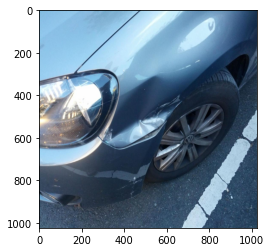

In [117]:
imgTest = Image.open('/input/test/60.jpg').convert('RGB')
plt.imshow(imgTest)

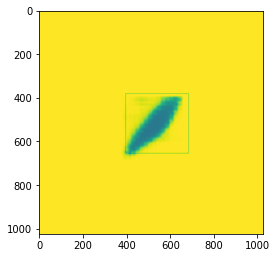

In [118]:
ShowPredictions('/input/test/','60.jpg',0.5)

### Case \#2 using a treshold of 0.4

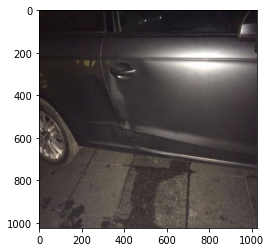

In [119]:
imgTest = Image.open('/input/test/12.jpg').convert('RGB')
plt.imshow(imgTest)

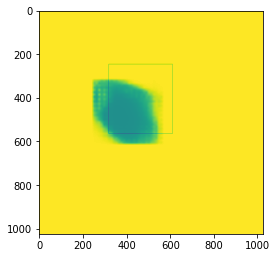

In [121]:
ShowPredictions('/input/test/','12.jpg',0.4)

### Case \#3 using a treshold of 0.5

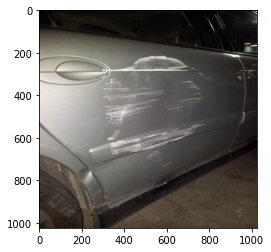

In [115]:
imgTest = Image.open('/input/test/11.jpg').convert('RGB')
plt.imshow(imgTest)

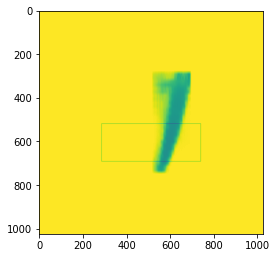

In [116]:
ShowPredictions('/input/test/','11.jpg',0.5)